In [1]:
from __future__ import annotations
import numpy as np
import math
from dataclasses import dataclass
from typing import Literal, Tuple, Dict, List
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace as dc_replace

In [ ]:
@dataclass
class params:
    S0: float      # initial asset price
    v0: float      # initial variance
    r: float       # risk‑free rate
    kappa: float   # mean‑reversion speed of v_t
    theta: float   # long‑run variance
    xi: float      # volatility of volatility ("vol‑of‑vol")
    rho: float     # correlation between dW_S and dW_v
    T: float       # option maturity in years
    K: float       # strike price
    N: int         # number of time steps
    M: int         # number of Monte Carlo paths

p = params(
    S0=100.0,
    v0=0.04,  # 20% vol²
    r=0.06,
    kappa=2.0,
    theta=0.04,
    xi=0.25,
    rho=-0.9,
    T=1.0,
    K=100.0,
    N=1000,
    M=10000
)


In [23]:
class AssetPath():
    def __init__(self, p: params):
        self.parameters = p
        self.Z1, self.Z2 = self.correlated_normals(p.rho, [p.M,p.N])

    def correlated_normals(self, rho: float, size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
        np.random.seed(42)
        z1 = np.random.normal(size=size)
        z2 = np.random.standard_normal(size=size)
        z2 = rho * z1 + np.sqrt(1.0 - rho**2) * z2
        return z1, z2

    def simulate_heston_paths(self, scheme: str) -> Tuple[np.ndarray, np.ndarray]:
        dt = self.parameters.T / self.parameters.N
        sqrt_dt = np.sqrt(dt)

        S = np.zeros((self.parameters.M, self.parameters.N + 1))
        v = np.zeros_like(S)
        S[:, 0] = self.parameters.S0
        v[:, 0] = self.parameters.v0

        dW_S = sqrt_dt * self.Z1
        dW_v = sqrt_dt * self.Z2

        for n in range(self.parameters.N):
            v_prev = v[:, n]
            S_prev = S[:, n]

            if scheme == "euler":
                v_next = (
                    v_prev
                    + self.parameters.kappa * (self.parameters.theta - v_prev) * dt
                    + self.parameters.xi * np.sqrt(np.maximum(v_prev, 0.0)) * dW_v[:, n]
                )
                v_next = np.maximum(v_next, 0.0)

                S_next = S_prev * np.exp(
                    (self.parameters.r - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW_S[:, n]
                )

            elif scheme == "milstein":
                sqrt_v = np.sqrt(np.maximum(v_prev, 0.0))
                v_next = (
                    v_prev
                    + self.parameters.kappa * (self.parameters.theta - v_prev) * dt
                    + self.parameters.xi * sqrt_v * dW_v[:, n]
                    + 0.25 * self.parameters.xi * self.parameters.xi * dt * (self.Z2[:, n] ** 2 - 1)
                )
                v_next = np.maximum(v_next, 0.0)

                S_next = S_prev * np.exp(
                    (self.parameters.r - 0.5 * v_prev)* dt + sqrt_v * dW_S[:, n] + 0.5 * v_prev * dt * (self.Z2[:, n] ** 2 - 1)
                )
                S_next = np.maximum(S_next, 0.0)

            S[:, n + 1] = S_next
            v[:, n + 1] = v_next

        return S, v

    def simulate_gbm_paths(self, scheme: str, sigma_hat:float) -> np.ndarray:
        dt = self.parameters.T / self.parameters.N
        sqrt_dt = np.sqrt(dt)

        S = np.zeros((self.parameters.M, self.parameters.N + 1))
        S[:, 0] = self.parameters.S0

        dW_S = sqrt_dt * self.Z1
        for n in range(self.parameters.N):
            S_prev = S[:, n]

            if scheme == "euler":

                S_next = S_prev * np.exp(
                    (self.parameters.r - 0.5 * sigma_hat**2) * dt + sigma_hat * dW_S[:, n]
                )

            elif scheme == "milstein":

                S_next = S_prev * np.exp(
                    (self.parameters.r - 0.5 * sigma_hat**2) * dt + sigma_hat * dW_S[:, n] 
                )

            S[:, n + 1] = S_next

        return S

In [24]:

assetpath = AssetPath(p)

heston_euler_asset,_ = assetpath.simulate_heston_paths(scheme='euler')
heston_milstein_asset,_ = assetpath.simulate_heston_paths(scheme='milstein')

BS_euler_asset = assetpath.simulate_gbm_paths(scheme='euler',sigma_hat=np.sqrt(p.v0))
BS_milstein_asset = assetpath.simulate_gbm_paths(scheme='milstein',sigma_hat=np.sqrt(p.v0))

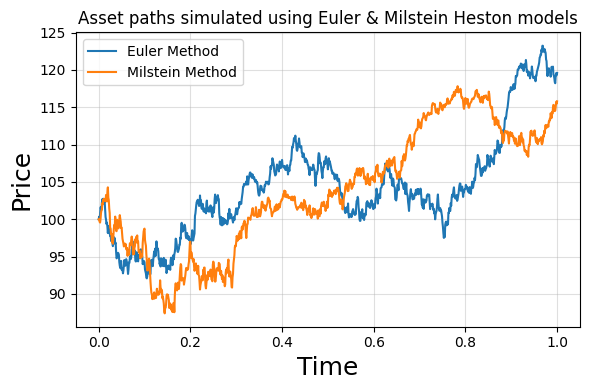

In [25]:
x = np.linspace(0,p.T,p.N+1)
plt.figure(figsize=(6, 4))
plt.plot(x, heston_euler_asset[0,:], label='Euler Method')
plt.plot(x, heston_milstein_asset[8,:], label='Milstein Method')
plt.title('Asset paths simulated using Euler & Milstein Heston models')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Euler  price = 6.0719  ± 0.1343 (95% CI)
Milstein price = 6.0723  ± 0.1343 (95% CI)


/var/folders/gn/r8l5ghp101qbw_sv8xpstssc0000gn/T/ipykernel_52524/4185070797.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


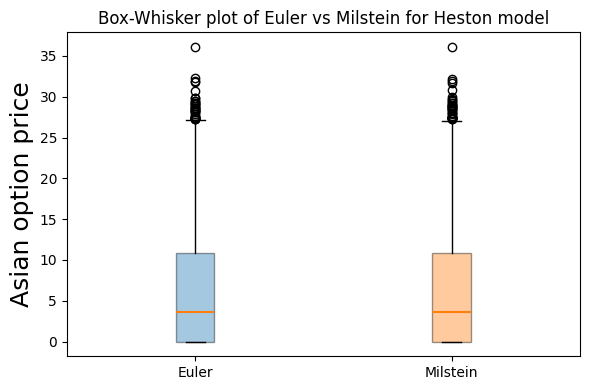

In [26]:
def asian_option_price(S: np.ndarray, p: params) -> Tuple[float, float]:
    avg_price = S.mean(axis=1)
    payoff = np.exp(-p.r * p.T) * np.maximum(avg_price - p.K, 0.0)
    price = payoff.mean()
    stderr = payoff.std(ddof=1) / np.sqrt(p.M)
    return price, stderr, payoff

heston_euler_price, heston_euler_error, heston_euler_dist = asian_option_price(heston_euler_asset, p)
print(f"Euler  price = {heston_euler_price:.4f}  ± {1.96 * heston_euler_error:.4f} (95% CI)")

heston_milstein_price, heston_milstein_error, heston_milstein_dist = asian_option_price(heston_milstein_asset, p)
print(f"Milstein price = {heston_milstein_price:.4f}  ± {1.96 * heston_milstein_error:.4f} (95% CI)")

fig, ax = plt.subplots(figsize=(6, 4))

box = ax.boxplot(
    [heston_euler_dist, heston_milstein_dist],
    labels=["Euler", "Milstein"],
    patch_artist=True,
    showfliers=True,
    medianprops=dict(linewidth=1.5, linestyle="-")
)

# optional nicer colors if available
colors = ["tab:blue", "tab:orange"]
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

ax.set_ylabel("Asian option price", fontsize=18)
ax.set_title("Box-Whisker plot of Euler vs Milstein for Heston model")

plt.tight_layout()
plt.show()

In [27]:
BS_euler_price, BS_euler_error, BS_euler_dist = asian_option_price(BS_euler_asset, p)
print(f"BS Euler  price = {BS_euler_price:.4f}  ± {1.96 * BS_euler_error:.4f} (95% CI)")
BS_milstein_price, BS_milstein_error, BS_milstein_dist = asian_option_price(BS_milstein_asset, p)
print(f"BS Milstein  price = {BS_milstein_price:.4f}  ± {1.96 * BS_milstein_error:.4f} (95% CI)")

p_check = p
p_check.xi = 0.0

asset_check = AssetPath(p_check)
mil_SC, mil_VC = asset_check.simulate_heston_paths(scheme='milstein')
eu_SC, eu_VC = asset_check.simulate_heston_paths(scheme='euler')

HC_milstein_xi, HC_milstein_xi_error,_ = asian_option_price(mil_SC, p_check)
print(f"Xi=0 Milstein price = {HC_milstein_xi:.4f}  ± {1.96 * HC_milstein_xi_error:.4f} (95% CI)")

diff_HC = abs(HC_milstein_xi - BS_milstein_price)
print(f"Absolute difference for Milstein: {diff_HC:.10f}")

HC_eu_xi, HC_eu_xi_error,_ = asian_option_price(eu_SC, p_check)
print(f"Xi=0 Euler price = {HC_eu_xi:.4f}  ± {1.96 * HC_eu_xi_error:.4f} (95% CI)")

diff_eu = abs(HC_eu_xi - BS_euler_price)
print(f"Absolute difference for euler: {diff_eu:.10f}")

BS Euler  price = 6.0053  ± 0.1581 (95% CI)
BS Milstein  price = 6.0053  ± 0.1581 (95% CI)
Xi=0 Milstein price = 6.0056  ± 0.1581 (95% CI)
Absolute difference for Milstein: 0.0003137960
Xi=0 Euler price = 6.0053  ± 0.1581 (95% CI)
Absolute difference for euler: 0.0000000000


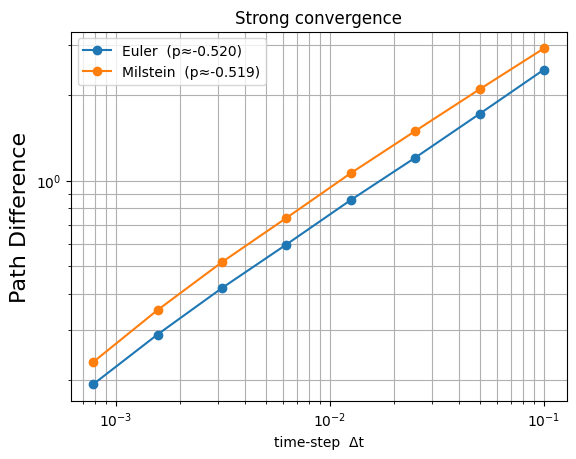

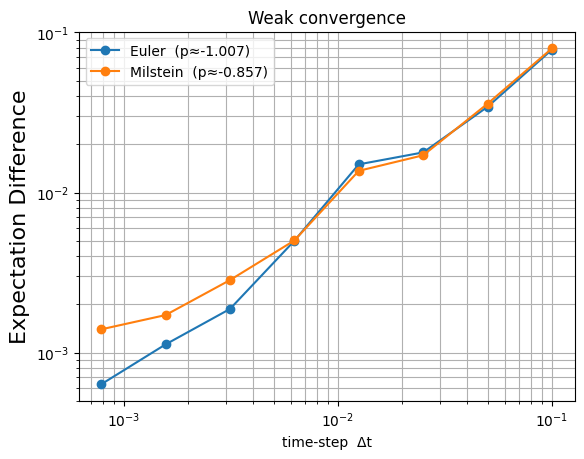

Euler    strong order ≈ 0.520
Milstein strong order ≈ 0.519
Euler    weak order ≈ 1.007
Milstein weak order ≈ 0.857


In [28]:
def aggregate_normals(z_fine: np.ndarray, factor: int) -> np.ndarray:
    """
    Convert fine-grid N(0,1) samples to coarse-grid N(0,1) samples by
    summing groups of `factor` and scaling by √factor.
    """
    m, n_ref = z_fine.shape
    assert n_ref % factor == 0, "N_ref must be an integer multiple of N_coarse"
    return z_fine.reshape(m, -1, factor).sum(axis=2) / np.sqrt(factor)

# -------- core routine: simulate and gather errors for many Δt ------------

def convergence_test(
    p0: params,
    N_ref: int,
    N_list: List[int],
    schemes: Tuple[str, ...] = ("euler", "milstein"),
    seed: int = 1234,
) -> Tuple[np.ndarray, Dict[str, List[float]], Dict[str, List[float]]]:

    np.random.seed(seed)
    M = p0.M

    # ---- reference (very fine) correlated normals ------------------------
    Z1_ref = np.random.standard_normal((M, N_ref))
    Z2_ind = np.random.standard_normal((M, N_ref))
    Z2_ref = p0.rho * Z1_ref + np.sqrt(1.0 - p0.rho ** 2) * Z2_ind

    # ---- reference path with Milstein on fine grid -----------------------
    p_ref = dc_replace(p0, N=N_ref)
    AP_ref = AssetPath(p_ref)
    AP_ref.Z1, AP_ref.Z2 = Z1_ref, Z2_ref
    S_ref, _ = AP_ref.simulate_heston_paths(scheme="milstein")
    price_ref, _, _ = asian_option_price(S_ref, p_ref)

    # containers
    strong_err: Dict[str, List[float]] = {s: [] for s in schemes}
    weak_err:   Dict[str, List[float]] = {s: [] for s in schemes}

    # ---- loop over coarse grids -----------------------------------------
    for N in N_list:
        factor = N_ref // N
        dt = p0.T / N

        Z1_c = aggregate_normals(Z1_ref, factor)
        Z2_c = aggregate_normals(Z2_ref, factor)

        p_c = dc_replace(p0, N=N)
        for scheme in schemes:
            AP_c = AssetPath(p_c)
            AP_c.Z1, AP_c.Z2 = Z1_c, Z2_c
            S_c, _ = AP_c.simulate_heston_paths(scheme=scheme)

            # strong error at maturity
            strong_err[scheme].append(np.mean(np.abs(S_c[:, -1] - S_ref[:, -1])))

            # weak error: Asian call price
            price_c, _, _ = asian_option_price(S_c, p_c)
            weak_err[scheme].append(abs(price_c - price_ref))

    dts = np.array([p0.T / N for N in N_list])
    return dts, strong_err, weak_err

# ---------------- plotting & order-of-convergence helpers -----------------

def loglog_plot(
    dts,                       # 1-D array of Δt values
    errors,                    # dict {scheme: list[error]}
    title: str,
    ylabel: str,
    label_fmt: str = "{scheme}  (p≈{slope:.3f})",
    annotate_points: bool = False,   # optional: set True to write y-values next to dots
):
    for scheme, err in errors.items():
        # --- slope via linear fit in log-log space -----------------------
        coeff = np.polyfit(np.log(dts), np.log(err), 1)
        slope = -coeff[0]              # coeff[0] is negative
        label = label_fmt.format(scheme=scheme.capitalize(), slope=slope)

        plt.loglog(dts, err, marker="o", label=label)

        if annotate_points:
            for x, y in zip(dts, err):
                plt.annotate(
                    f"{y:.2e}",
                    xy=(x, y),
                    xytext=(4, 2),
                    textcoords="offset points",
                    fontsize=7,
                )

    plt.xlabel("time-step  Δt")
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title)
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


def print_orders(dts: np.ndarray, errors: Dict[str, List[float]], label: str):
    for scheme, err in errors.items():
        slope, _ = np.polyfit(np.log(dts), np.log(err), 1)
        print(f"{scheme.capitalize():8s} {label} order ≈ {abs(slope):5.3f}")

# ------------------------------ driver ------------------------------------

if __name__ == "__main__":
    # -- base parameters (same as in your example) ------------------------
    p = params(
        S0=100.0, v0=0.04, r=0.06,
        kappa=2.0, theta=0.04, xi=0.25, rho=-0.9,
        T=1.0, K=100.0,
        N=1000,      # placeholder – will be overwritten
        M=10_000     # Monte-Carlo paths
    )

    # grids: every point halves Δt
    N_list  = [ 10, 20, 40, 80, 160, 320, 640, 1280 ]
    N_ref   = 5120                              # very fine grid (must be multiple of every N in N_list)

    dts, strong, weak = convergence_test(p, N_ref, N_list)

    # ---- plots ----------------------------------------------------------
    loglog_plot(dts, strong, "Strong convergence", "Path Difference")
    loglog_plot(dts, weak,   "Weak convergence",   "Expectation Difference")

    # ---- numerical orders ----------------------------------------------
    print_orders(dts, strong, "strong")
    print_orders(dts, weak,   "weak")

In [29]:
def equivalent_volatility(params: params, T: float) -> float:
    k, v0, th = params.kappa, params.v0, params.theta
    return math.sqrt(th + (v0 - th) * (1.0 - math.exp(-k * T)) / (k * T))


def geometric_asian_call_bs(
    S0: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    N: int
) -> float:
    # Pre‑compute factors
    sigma_hat = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    r_hat = (r - 0.5*(sigma**2) + sigma_hat**2)/2

    d1 = (np.log(S0/K) + (r_hat + 0.5*(sigma_hat**2))*T)/(np.sqrt(T)*sigma_hat)
    d2 = (np.log(S0/K) + (r_hat - 0.5*(sigma_hat**2))*T)/(np.sqrt(T)*sigma_hat)

    price =S0*np.exp((r_hat - r)*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return price


sigma_hat = equivalent_volatility(p, p.T)
C_G = geometric_asian_call_bs(p.S0, p.K, p.r, sigma_hat, p.T, p.N)
print(f"  σ̂ = {sigma_hat:.4f}\n  Price = {C_G:.4f}")

#Sanity Check
bs_ref = geometric_asian_call_bs(p.S0, p.K, p.r, math.sqrt(p.v0), p.T, p.N)
print("\nSanity GBM: MC Euler = {:.4f}  Analytic = {:.4f}  |Δ| = {:.4e}".format(HC_eu_xi, bs_ref, abs(HC_eu_xi - bs_ref)))
print("\nSanity GBM: MC Milstein = {:.4f}  Analytic = {:.4f}  |Δ| = {:.4e}".format(HC_milstein_xi, bs_ref, abs(HC_milstein_xi - bs_ref)))


  σ̂ = 0.2000
  Price = 5.7823

Sanity GBM: MC Euler = 6.0053  Analytic = 5.7823  |Δ| = 2.2294e-01

Sanity GBM: MC Milstein = 6.0056  Analytic = 5.7823  |Δ| = 2.2325e-01


In [30]:
from typing import Tuple
import numpy as np

def geometric_asian_call(
    S: np.ndarray,  # shape (M, N+1) or (M, N)
    p              # your params dataclass
) -> Tuple[float, float, np.ndarray]:
    """
    Monte-Carlo price of a *discrete* geometric-average Asian call.
    Uses every column of S except the initial spot S[:,0] if you included it.
    """
    # drop S0 if it is included
    prices = S[:, 1:] if S.shape[1] == p.N + 1 else S

    G = np.exp(np.mean(np.log(prices), axis=1))       # geometric mean
    payoff = np.exp(-p.r * p.T) * np.maximum(G - p.K, 0.0)

    price  = payoff.mean()
    stderr = payoff.std(ddof=1) / np.sqrt(p.M)
    return price, stderr, payoff


geo_euler_price, geo_euler_error, geo_euler_dist = geometric_asian_call(BS_euler_asset, p)
print(f"BS Euler  price = {geo_euler_price:.4f}  ± {1.96 * geo_euler_error:.4f} (95% CI)")
geo_milstein_price, geo_milstein_error, geo_milstein_dist = geometric_asian_call(BS_milstein_asset, p)
print(f"BS Milstein  price = {geo_milstein_price:.4f}  ± {1.96 * geo_milstein_error:.4f} (95% CI)")

BS Euler  price = 5.7882  ± 0.1528 (95% CI)
BS Milstein  price = 5.7882  ± 0.1528 (95% CI)


In [31]:
def control_variate(
        Y: np.ndarray,
        X: np.ndarray,
        C_G: float,
        M:int,
        c = None,
        ):

    # Plain estimator
    mean_Y = Y.mean()
    se_Y = Y.std(ddof=1) / math.sqrt(M)
    if c == None:
        c=1
    else:
        c = np.cov(Y,X,ddof=1)[0,1]/(X.var(ddof=1))
    # Control‑variate
    Z = Y + c * (C_G - X)
    mean_Z = Z.mean() 
    se_Z = Z.std(ddof=1) / math.sqrt(p.M)

    vr = (se_Y * se_Y) / (se_Z * se_Z)
    return {
        "plain_price": mean_Y,
        "plain_se": se_Y,
        "cv_price": mean_Z,
        "cv_se": se_Z,
        "var_reduction": vr,
        "Plain Var": (se_Y * se_Y),
        "Control Var": (se_Z * se_Z)
    }

output_euler = control_variate(heston_euler_dist,geo_euler_dist, C_G, p.M, None, )

print("\nArithmetic‑Average Asian Call under Heston Euler")
print("──────────────────────────────────────────")
print(f"Plain MC   : {output_euler['plain_price']:.6f}  ± {1.96*output_euler['plain_se']:.6f} (95% CI)")
print(f"Control‑Var: {output_euler['cv_price']:.6f}  ± {1.96*output_euler['cv_se']:.6f}")
print(f"Variance reduction ≈ {output_euler['var_reduction']:.1f}×")

output_milstein = control_variate(heston_milstein_dist,geo_milstein_dist, C_G, p.M, None, )

print("\nArithmetic‑Average Asian Call under Heston Milstein")
print("──────────────────────────────────────────")
print(f"Plain MC   : {output_milstein['plain_price']:.6f}  ± {1.96*output_milstein['plain_se']:.6f} (95% CI)")
print(f"Control‑Var: {output_milstein['cv_price']:.6f}  ± {1.96*output_milstein['cv_se']:.6f}")
print(f"Variance reduction ≈ {output_milstein['var_reduction']:.1f}×")




Arithmetic‑Average Asian Call under Heston Euler
──────────────────────────────────────────
Plain MC   : 6.071881  ± 0.134266 (95% CI)
Control‑Var: 6.066071  ± 0.040983
Variance reduction ≈ 10.7×

Arithmetic‑Average Asian Call under Heston Milstein
──────────────────────────────────────────
Plain MC   : 6.072279  ± 0.134323 (95% CI)
Control‑Var: 6.066469  ± 0.040927
Variance reduction ≈ 10.8×


In [ ]:
output_milstein_check = control_variate(heston_milstein_dist,geo_milstein_dist, C_G, p.M, 1)

print("\nArithmetic‑Average Asian Call under Heston Milstein")
print("──────────────────────────────────────────")
print(f"Plain MC   : {output_milstein_check['plain_price']:.6f}  ± {1.96*output_milstein_check['plain_se']:.6f} (95% CI)")
print(f"Control‑Var: {output_milstein_check['cv_price']:.6f}  ± {1.96*output_milstein_check['cv_se']:.6f}")
print(f"Variance reduction ≈ {output_milstein_check['var_reduction']:.1f}×")


Arithmetic‑Average Asian Call under Heston Euler
──────────────────────────────────────────
Plain MC   : 6.072279  ± 0.134323 (95% CI)
Control‑Var: 6.067337  ± 0.033972
Variance reduction ≈ 15.6×


In [34]:
print(output_milstein_check['Control Var'])

0.00030041680083729125


In [33]:
M = [100,1000,10000,100000]

mil = []
euler = []

for m in M:
    print('M=',m)
    for scheme in ['euler', 'milstein']:
        p_dummy = dc_replace(p, M=m)
        AP_dummy = AssetPath(p_dummy)
        if scheme == 'milstein':
            heston_asset, _ = AP_dummy.simulate_heston_paths(scheme="milstein")
            _, _, heston_dist = asian_option_price(heston_asset, p_dummy)
            BS_asset = AP_dummy.simulate_gbm_paths(scheme='milstein',sigma_hat=np.sqrt(p_dummy.v0))
            _, _, BS_dist = geometric_asian_call(BS_asset, p_dummy)
            output = control_variate(heston_milstein_dist,geo_milstein_dist, C_G, p_dummy.M, 1)
            mil.append(output)
        elif scheme == 'euler':
                heston_asset, _ = AP_dummy.simulate_heston_paths(scheme="euler")
                _, _, heston_dist = asian_option_price(heston_asset, p_dummy)
                BS_asset = AP_dummy.simulate_gbm_paths(scheme='euler',sigma_hat=np.sqrt(p_dummy.v0))
                _, _, BS_dist = geometric_asian_call(BS_asset, p_dummy)
                output = control_variate(heston_milstein_dist,geo_milstein_dist, C_G, p_dummy.M, 1)
                euler.append(output)

M= 100
M= 1000
M= 10000
M= 100000


KeyboardInterrupt: 

In [ ]:
import pandas as pd

records = []
for m, d in zip(M, euler):
    records.append({**d, "M": m, "scheme": "Euler"})
for m, d in zip(M, mil):
    records.append({**d, "M": m, "scheme": "Milstein"})

df = (
    pd.DataFrame(records)
    .query("scheme == 'Milstein'")
    .sort_values("M")
    .reset_index(drop=True)
)

# colour & marker palette
plain_col, cv_col = "tab:blue", "tab:orange"
plain_mk,  cv_mk  = "o",        "s"

# -------------------------------------------------------------------------
# 2-A. PRICE ± 1 σ  (plain vs CV)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(df["M"], df["plain_price"], df["plain_se"],
            fmt=plain_mk, color=plain_col, capsize=3, label="Plain")
# ax.errorbar(df["M"], df["cv_price"], df["cv_se"],
#             fmt=cv_mk,    color=cv_col,   ls="--", capsize=3, label="Control variate")
ax.errorbar(df["M"], df["cv_price"], df["cv_se"],
            fmt="s", color="tab:orange", ls="none",   #  ← no line
            capsize=3, label="Control variate")

ax.set_xscale("log")
ax.set_xlabel(r"Number of paths  $M$", fontsize=14)
ax.set_ylabel("Estimated price",      fontsize=14)
ax.set_title("Price with / without control variate")
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2-B. STANDARD ERROR (log–log)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.loglog(df["M"], df["plain_se"],
          marker=plain_mk, color=plain_col, ls="-",  label="Plain")
ax.loglog(df["M"], df["cv_se"],
          marker=cv_mk,    color=cv_col,   ls="--", label="Control variate")

ax.set_xlabel(r"$M$", fontsize=14)
ax.set_ylabel("Standard error", fontsize=14)
ax.set_title("Standard error vs sample size")
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2-C. VARIANCE-REDUCTION FACTOR
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(np.arange(len(M)), df["var_reduction"], color=cv_col, width=0.45)

ax.set_xticks(np.arange(len(M)))
ax.set_xticklabels([f"{m:,}" for m in M])
ax.set_xlabel(r"Number of paths  $M$", fontsize=14)
ax.set_ylabel("Variance-reduction factor", fontsize=14)
ax.set_title("Efficiency gain from control variate")
plt.tight_layout()
plt.show()


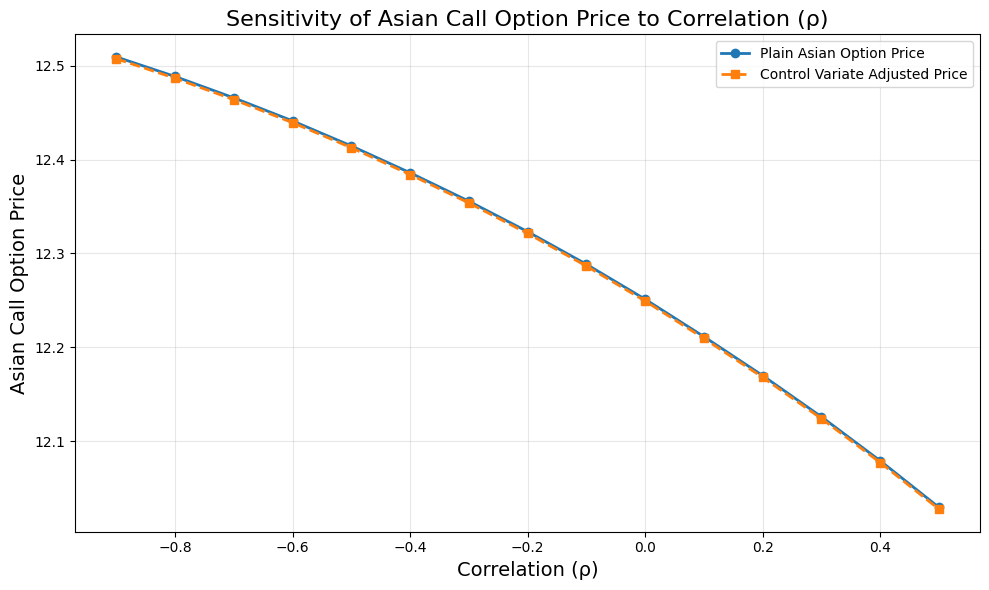

In [ ]:
# Sensitivity analysis function for rho parameter
def sensitivity_rho(
    p: params,
    rho_values: Sequence[float],
    scheme: str = "milstein",
    use_control_variate: bool = True
) -> pd.DataFrame:
    results = []

    for rho in rho_values:
        p_i = dataclasses.replace(p, rho=rho)
        ap = AssetPath(p_i)
        S_heston, _ = ap.simulate_heston_paths(scheme=scheme)
        price_Y, se_Y, payoff_Y = asian_option_price(S_heston, p_i)

        row = {
            "rho": rho,
            "plain_price": price_Y,
            "plain_se": se_Y,
            "cv_price": np.nan,
            "cv_se": np.nan,
            "var_reduction": np.nan,
        }

        if use_control_variate:
            sigma_eq = equivalent_volatility(p_i, p_i.T)
            C_G = geometric_asian_call_bs(S0=p_i.S0, K=p_i.K, r=p_i.r, sigma=sigma_eq, T=p_i.T, N=p_i.N)
            S_gbm = ap.simulate_gbm_paths(scheme=scheme, sigma_hat=sigma_eq)
            payoff_X = np.exp(-p_i.r * p_i.T) * np.maximum(np.exp(np.log(S_gbm).mean(axis=1)) - p_i.K, 0.0)
            
            cv_stats = control_variate(Y=payoff_Y, X=payoff_X, C_G=C_G, M=p_i.M)
            row.update(
                cv_price=cv_stats["cv_price"],
                cv_se=cv_stats["cv_se"],
                var_reduction=cv_stats["var_reduction"]
            )

        results.append(row)

    return pd.DataFrame(results)

# Running the sensitivity analysis on rho values
rho_values = np.linspace(-0.9, 0.5, 15)
p = params(S0=100.0, v0=0.04, r=0.06, kappa=2.0, theta=0.04, xi=0.25, rho=0.3, T=3.0, K=99.0, N=1000, M=10000)

# Perform the simulation
sensitivity_rho_df = sensitivity_rho(p, rho_values, scheme="milstein", use_control_variate=True)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_rho_df['rho'], sensitivity_rho_df['plain_price'], 'o-', linewidth=2, label='Plain Asian Option Price')
plt.plot(sensitivity_rho_df['rho'], sensitivity_rho_df['cv_price'], 's--', linewidth=2, label='Control Variate Adjusted Price')

plt.title('Sensitivity of Asian Call Option Price to Correlation (ρ)', fontsize=16)
plt.xlabel('Correlation (ρ)', fontsize=14)
plt.ylabel('Asian Call Option Price', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import dataclasses
import numpy as np
import pandas as pd
from typing import Iterable, Sequence, Dict, Any

def _geometric_payoff(S: np.ndarray, p: params) -> np.ndarray:
    """
    Discounted payoff of a geometric-average Asian call on one matrix of paths.
    """
    geom_avg = np.exp(np.log(S).mean(axis=1))          # ⟨product S⟩¹/ᴺ
    return np.exp(-p.r * p.T) * np.maximum(geom_avg - p.K, 0.0)

def sensitivity_xi(
    p: params,
    xi_values: Sequence[float] | None = None,
    scheme: str = "euler",
    use_control_variate: bool = True,
) -> pd.DataFrame:
    """
    Monte-Carlo sensitivity of the Asian-call price with respect to ξ (vol-of-vol).

    Parameters
    ----------
    p : params
        Baseline parameter object (other fields held constant).
    xi_values : iterable of float, optional
        Grid of ξ values to test.  Default = np.linspace(0.1, 1.0, 10).
    scheme : {"euler", "milstein"}
        Time-stepping scheme for both Heston and GBM control paths.
    use_control_variate : bool, default True
        If True, apply the geometric-Asian control-variate; otherwise report the
        plain arithmetic-Asian estimator only.

    Returns
    -------
    pandas.DataFrame
        One row per ξ with columns:
        ["xi", "plain_price", "plain_se",
         "cv_price", "cv_se", "var_reduction"]
        (The *_cv* columns are NaN if `use_control_variate=False`)
    """
    if xi_values is None:
        xi_values = np.linspace(0.1, 1.0, 10)

    results: list[Dict[str, Any]] = []

    for xi in xi_values:
        # 1) copy the param-object with the new ξ
        p_i = dataclasses.replace(p, xi=xi)

        # 2) simulate Heston paths (Y)
        ap = AssetPath(p_i)
        S_heston, _ = ap.simulate_heston_paths(scheme=scheme)
        price_Y, se_Y, payoff_Y = asian_option_price(S_heston, p_i)

        row = {
            "xi": xi,
            "plain_price": price_Y,
            "plain_se": se_Y,
            "cv_price": np.nan,
            "cv_se": np.nan,
            "var_reduction": np.nan,
        }

        # 3) optional control-variate
        if use_control_variate:
            # analytic expectation of geometric-Asian call under GBM with σ̂
            sigma_eq = equivalent_volatility(p_i, p_i.T)
            C_G      = geometric_asian_call_bs(
                S0=p_i.S0,
                K=p_i.K,
                r=p_i.r,
                sigma=sigma_eq,
                T=p_i.T,
                N=p_i.N
            )

            # correlated GBM sample paths (X) using the *same* Brownian increments
            S_gbm = ap.simulate_gbm_paths(scheme=scheme, sigma_hat=sigma_eq)
            payoff_X = _geometric_payoff(S_gbm, p_i)

            cv_stats = control_variate(
                Y=payoff_Y,
                X=payoff_X,
                C_G=C_G,
                M=p_i.M,
                c=None,               # c chosen optimally inside the helper
            )

            row.update(
                cv_price      = cv_stats["cv_price"],
                cv_se         = cv_stats["cv_se"],
                var_reduction = cv_stats["var_reduction"],
            )

        results.append(row)

    return pd.DataFrame(results)


In [ ]:
import dataclasses
import numpy as np
import pandas as pd
from typing import Iterable, Sequence, Dict, Any

def _geometric_payoff(S: np.ndarray, p: params) -> np.ndarray:
    """
    Discounted payoff of a geometric-average Asian call on one matrix of paths.
    """
    geom_avg = np.exp(np.log(S).mean(axis=1))          # ⟨product S⟩¹/ᴺ
    return np.exp(-p.r * p.T) * np.maximum(geom_avg - p.K, 0.0)

def sensitivity_xi(
    p: params,
    xi_values: Sequence[float] | None = None,
    scheme: str = "euler",
    use_control_variate: bool = True,
) -> pd.DataFrame:
    """
    Monte-Carlo sensitivity of the Asian-call price with respect to ξ (vol-of-vol).

    Parameters
    ----------
    p : params
        Baseline parameter object (other fields held constant).
    xi_values : iterable of float, optional
        Grid of ξ values to test.  Default = np.linspace(0.1, 1.0, 10).
    scheme : {"euler", "milstein"}
        Time-stepping scheme for both Heston and GBM control paths.
    use_control_variate : bool, default True
        If True, apply the geometric-Asian control-variate; otherwise report the
        plain arithmetic-Asian estimator only.

    Returns
    -------
    pandas.DataFrame
        One row per ξ with columns:
        ["xi", "plain_price", "plain_se",
         "cv_price", "cv_se", "var_reduction"]
        (The *_cv* columns are NaN if `use_control_variate=False`)
    """
    if xi_values is None:
        xi_values = np.linspace(0.1, 1.0, 10)

    results: list[Dict[str, Any]] = []

    for xi in xi_values:
        # 1) copy the param-object with the new ξ
        p_i = dataclasses.replace(p, xi=xi)

        # 2) simulate Heston paths (Y)
        ap = AssetPath(p_i)
        S_heston, _ = ap.simulate_heston_paths(scheme=scheme)
        price_Y, se_Y, payoff_Y = asian_option_price(S_heston, p_i)

        row = {
            "xi": xi,
            "plain_price": price_Y,
            "plain_se": se_Y,
            "cv_price": np.nan,
            "cv_se": np.nan,
            "var_reduction": np.nan,
        }

        # 3) optional control-variate
        if use_control_variate:
            # analytic expectation of geometric-Asian call under GBM with σ̂
            sigma_eq = equivalent_volatility(p_i, p_i.T)
            C_G      = geometric_asian_call_bs(
                S0=p_i.S0,
                K=p_i.K,
                r=p_i.r,
                sigma=sigma_eq,
                T=p_i.T,
                N=p_i.N
            )

            # correlated GBM sample paths (X) using the *same* Brownian increments
            S_gbm = ap.simulate_gbm_paths(scheme=scheme, sigma_hat=sigma_eq)
            payoff_X = _geometric_payoff(S_gbm, p_i)

            cv_stats = control_variate(
                Y=payoff_Y,
                X=payoff_X,
                C_G=C_G,
                M=p_i.M,
                c=None,               # c chosen optimally inside the helper
            )

            row.update(
                cv_price      = cv_stats["cv_price"],
                cv_se         = cv_stats["cv_se"],
                var_reduction = cv_stats["var_reduction"],
            )

        results.append(row)

    return pd.DataFrame(results)


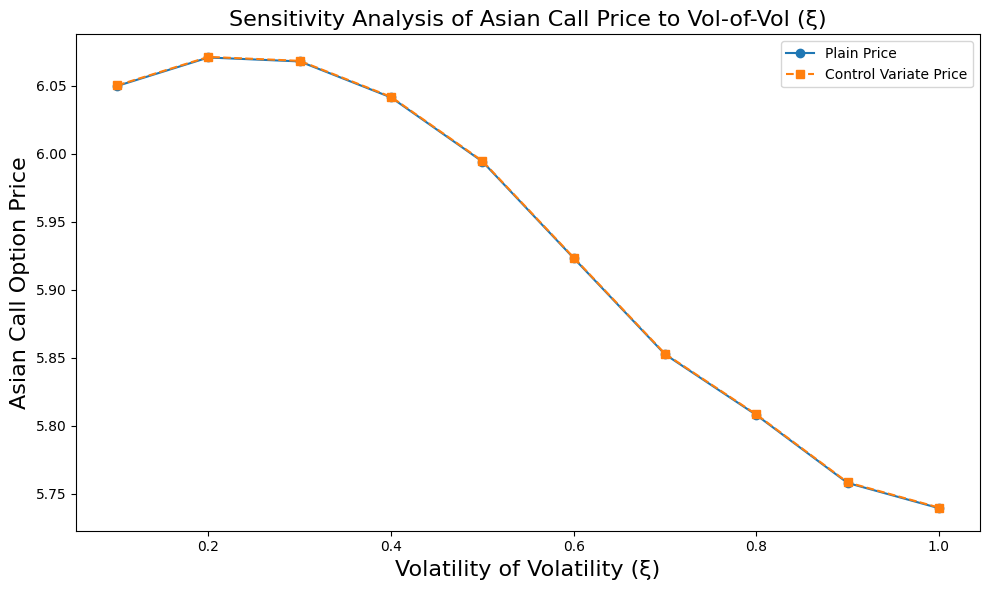

In [ ]:
xi_values = np.linspace(0.1, 1.0, 10)
sensitivity_df = sensitivity_xi(p, xi_values, scheme="milstein", use_control_variate=True)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_df['xi'], sensitivity_df['plain_price'], marker='o', linestyle='-', label='Plain Price')
plt.plot(sensitivity_df['xi'], sensitivity_df['cv_price'], marker='s', linestyle='--', label='Control Variate Price')

plt.title('Sensitivity Analysis of Asian Call Price to Vol-of-Vol (ξ)', fontsize=16)
plt.xlabel('Volatility of Volatility (ξ)', fontsize=16)
plt.ylabel('Asian Call Option Price', fontsize=16)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


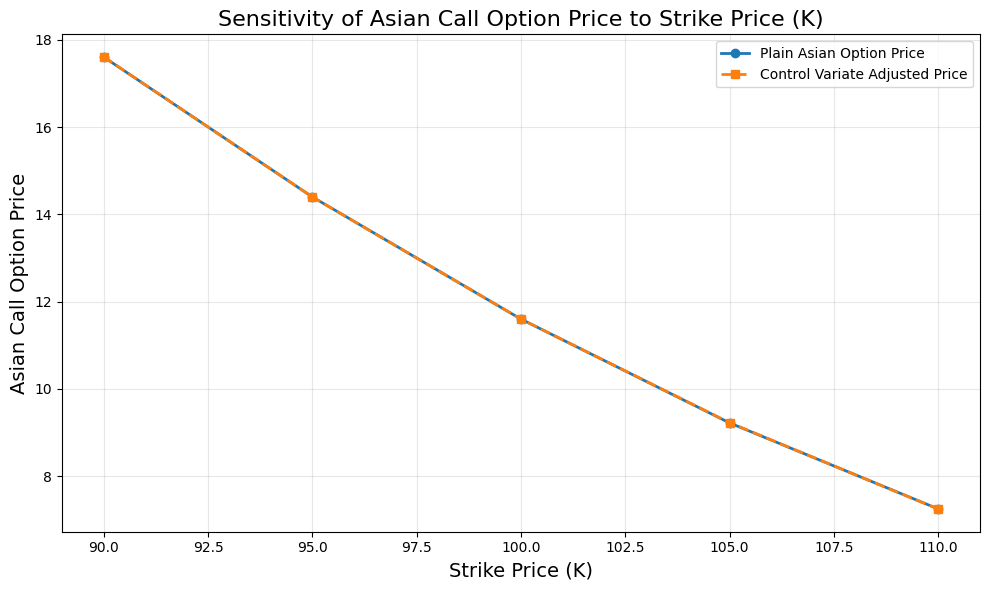

In [ ]:
def sensitivity_K(
    p: params,
    K_values: Sequence[float],
    scheme: str = "milstein",
    use_control_variate: bool = True
) -> pd.DataFrame:
    results = []

    for K in K_values:
        p_i = dataclasses.replace(p, K=K)
        ap = AssetPath(p_i)
        S_heston, _ = ap.simulate_heston_paths(scheme=scheme)
        price_Y, se_Y, payoff_Y = asian_option_price(S_heston, p_i)

        row = {
            "K": K,
            "plain_price": price_Y,
            "plain_se": se_Y,
            "cv_price": np.nan,
            "cv_se": np.nan,
            "var_reduction": np.nan,
        }

        if use_control_variate:
            sigma_eq = equivalent_volatility(p_i, p_i.T)
            C_G = geometric_asian_call_bs(S0=p_i.S0, K=p_i.K, r=p_i.r, sigma=sigma_eq, T=p_i.T, N=p_i.N)
            S_gbm = ap.simulate_gbm_paths(scheme=scheme, sigma_hat=sigma_eq)
            payoff_X = np.exp(-p_i.r * p_i.T) * np.maximum(np.exp(np.log(S_gbm).mean(axis=1)) - p_i.K, 0.0)
            
            cv_stats = control_variate(Y=payoff_Y, X=payoff_X, C_G=C_G, M=p_i.M)
            row.update(
                cv_price=cv_stats["cv_price"],
                cv_se=cv_stats["cv_se"],
                var_reduction=cv_stats["var_reduction"]
            )

        results.append(row)

    return pd.DataFrame(results)

# Running the sensitivity analysis on strike prices
K_values = [90, 95, 100, 105, 110]  # Corrected typo (repeated 100 replaced with 110)
p = params(S0=100.0, v0=0.04, r=0.06, kappa=2.0, theta=0.04, xi=0.25, rho=0.3, T=3.0, K=99.0, N=1000, M=10000)

# Perform the simulation
sensitivity_K_df = sensitivity_K(p, K_values, scheme="milstein", use_control_variate=True)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_K_df['K'], sensitivity_K_df['plain_price'], 'o-', linewidth=2, label='Plain Asian Option Price')
plt.plot(sensitivity_K_df['K'], sensitivity_K_df['cv_price'], 's--', linewidth=2, label='Control Variate Adjusted Price')

plt.title('Sensitivity of Asian Call Option Price to Strike Price (K)', fontsize=16)
plt.xlabel('Strike Price (K)', fontsize=14)
plt.ylabel('Asian Call Option Price', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
